In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `ArtMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import ArtMix

from vision_models_evaluation.core import evaluate
from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "ArtMix"
}

`ArtMix` is a technique that allows the user to create a whole new set of masks depending on real .png files.

Given a path to a file (which is typically black and white, but works well on gray-scale even on colored images), this technique converts the image in that file into a binary mask. Its content can be reversed (so that the user can mark the interesting part as black or white).

Finally, the mask is added into a rectangular frame and overlapped with the augmented image, adding the black part of the mask (after the revertion) with Transparency (defined earlier in `TransparenceMix`).

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


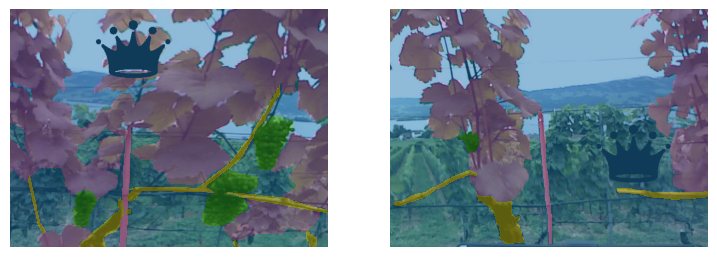

In [ ]:
cv = ArtMix("crown_mask.png", holes_num = 1, hole_maker = HoleMakerBounded(hole_size = (150, 150)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cv) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cv.x, cv.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for mask_file in ["square_mask", "circle_mask", "cross_mask", "crown_mask"]:
    for size in [(150, 150), (250, 250)]:
        for holes_num in [1, 2]:
            tm = ArtMix(f"{mask_file}.png", holes_num = holes_num, hole_maker = HoleMakerBounded(hole_size = size))
            learner_hparams["cbs"] = [esc, tm]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                mask_file + str(size) + str(holes_num): r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,1.023736,0.829277,0.323979,00:21
1,0.702166,0.484590,0.347142,00:19
2,0.585662,0.495093,0.479528,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.378220,0.339429,0.677590,00:19
1,0.346670,0.327211,0.724581,00:19
2,0.326587,0.310226,0.720709,00:20
3,0.315152,0.321759,0.704528,00:19
4,0.302778,0.300943,0.750056,00:19
5,0.297249,0.287957,0.754030,00:19
6,0.301843,0.320681,0.739970,00:19
7,0.310435,0.301254,0.749301,00:19
8,0.305000,0.298444,0.766564,00:19
9,0.280791,0.292215,0.776046,00:19


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.22675959765911102  /  DiceMulti: 0.827719519934686  
Saving best model because DiceMulti 0.8277 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.923565,0.685031,0.339479,00:19
1,0.678966,0.437927,0.354003,00:20
2,0.580978,0.548844,0.456034,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.387387,0.328000,0.574104,00:20
1,0.353410,0.292268,0.717376,00:20
2,0.339505,0.286814,0.769318,00:20
3,0.326499,0.350801,0.706622,00:20
4,0.311696,0.265893,0.767876,00:20
5,0.295804,0.280872,0.796938,00:20
6,0.312508,0.294531,0.759780,00:19
7,0.312223,0.300773,0.595596,00:20
8,0.307586,0.291931,0.765679,00:21
9,0.293786,0.268467,0.809772,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2385774403810501  /  DiceMulti: 0.8152312215092214  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.215568,0.781747,0.295378,00:19
1,0.810493,0.520284,0.363919,00:20
2,0.927945,0.942396,0.238156,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.555893,0.418368,0.352723,00:20
1,0.497913,0.443436,0.349691,00:20
2,0.440828,0.355913,0.573153,00:20
3,0.399756,0.322689,0.689691,00:21
4,0.363460,0.307627,0.739271,00:20
5,0.355584,0.335711,0.693120,00:20
6,0.336618,0.290593,0.765626,00:20
7,0.324311,0.314893,0.693121,00:20
8,0.304987,0.299932,0.766579,00:20
9,0.293713,0.274139,0.766310,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.17302843928337097  /  DiceMulti: 0.8761217109997281  
Saving best model because DiceMulti 0.8761 >= 0.8277.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.970839,0.666955,0.320121,00:19
1,0.670592,0.562482,0.420464,00:20
2,0.692706,2.457713,0.256127,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.771310,0.359986,0.360985,00:19
1,0.554835,0.322786,0.543891,00:19
2,0.469030,0.285935,0.652006,00:20
3,0.410094,0.255719,0.732365,00:20
4,0.370364,0.247543,0.762767,00:19
5,0.358549,0.333629,0.661031,00:19
6,0.341560,0.253674,0.746586,00:20
7,0.363137,0.321063,0.798213,00:20
8,0.346309,0.240866,0.810336,00:20
9,0.322926,0.225531,0.800959,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.204216867685318  /  DiceMulti: 0.8571557972226271  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.853311,0.560778,0.347493,00:19
1,0.632558,0.615529,0.337342,00:20
2,1.684540,1.336853,0.118919,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.610937,0.454372,0.354646,00:20
1,0.484639,0.438159,0.369155,00:20
2,0.439113,0.357703,0.581451,00:20
3,0.392294,0.305146,0.687298,00:20
4,0.346839,0.277346,0.741238,00:20
5,0.322593,0.305390,0.716821,00:20
6,0.324614,0.325494,0.780477,00:20
7,0.310459,0.260963,0.803672,00:20
8,0.298593,0.299376,0.780536,00:20
9,0.296985,0.266271,0.779108,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.26826968789100647  /  DiceMulti: 0.762674030032179  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.944533,0.807630,0.271611,00:20
1,0.693960,0.819925,0.452504,00:20
2,0.631732,0.539277,0.446052,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.370633,0.520734,0.554373,00:20
1,0.357143,0.460501,0.607584,00:20
2,0.334176,0.582744,0.652996,00:20
3,0.316984,0.525468,0.695364,00:20
4,0.297147,0.475318,0.714073,00:20
5,0.277614,0.420903,0.678826,00:20
6,0.263799,0.516368,0.701793,00:20
7,0.263077,0.521189,0.689576,00:20
8,0.254219,0.395120,0.740436,00:20
9,0.247809,0.515628,0.650627,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.1732182800769806  /  DiceMulti: 0.8700095093632552  
Saving best model because DiceMulti 0.87 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.988954,0.613826,0.337962,00:20
1,0.752292,0.531593,0.344142,00:19
2,0.919019,1.108958,0.214142,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.548497,0.442762,0.353127,00:20
1,0.476998,0.409486,0.353794,00:20
2,0.426603,0.352272,0.562642,00:20
3,0.395442,0.389743,0.429756,00:21
4,0.363889,0.315992,0.703260,00:20
5,0.341601,0.335724,0.748898,00:20
6,0.333688,0.359869,0.722886,00:21
7,0.315608,0.273724,0.797269,00:20
8,0.304739,0.282174,0.795508,00:20
9,0.302698,0.300191,0.754018,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.23205968737602234  /  DiceMulti: 0.8514650693501918  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.006839,1.072099,0.242327,00:20
1,0.779516,0.528852,0.345471,00:20
2,0.620732,0.386204,0.409898,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.384033,0.345413,0.561456,00:20
1,0.350118,0.318055,0.689296,00:20
2,0.335386,0.340931,0.590672,00:21
3,0.326023,0.310247,0.733503,00:20
4,0.318699,0.330743,0.642757,00:20
5,0.311852,0.289693,0.773355,00:20
6,0.299416,0.286316,0.780172,00:20
7,0.288470,0.284776,0.781384,00:20
8,0.285567,0.324619,0.778200,00:20
9,0.278540,0.283789,0.794530,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.16474781930446625  /  DiceMulti: 0.8700153474420933  
Saving best model because DiceMulti 0.87 >= 0.87.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.005750,0.526772,0.357514,00:19
1,0.670154,0.370667,0.380642,00:20
2,0.733875,1.142035,0.168158,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.692698,0.387347,0.360644,00:20
1,0.523625,0.297407,0.588091,00:20
2,0.445975,0.286698,0.662457,00:20
3,0.392707,0.256494,0.708702,00:20
4,0.355370,0.243595,0.773634,00:20
5,0.339635,0.262464,0.723944,00:20
6,0.311725,0.233385,0.760361,00:20
7,0.294457,0.228524,0.800958,00:20
8,0.303705,0.282409,0.789072,00:20
9,0.315227,0.289378,0.801970,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.23468244075775146  /  DiceMulti: 0.845883770443536  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.984183,0.843737,0.266977,00:19
1,0.679506,0.477846,0.382845,00:20
2,0.606514,0.485579,0.347707,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.388731,0.373783,0.546746,00:20
1,0.360736,0.336088,0.674125,00:20
2,0.360927,0.364594,0.707211,00:20
3,0.334149,0.292963,0.755089,00:21
4,0.311032,0.287716,0.769476,00:21
5,0.301256,0.268950,0.785792,00:20
6,0.291905,0.302714,0.759409,00:20
7,0.302726,0.292806,0.752999,00:20
8,0.289327,0.280443,0.792274,00:20
9,0.283418,0.263681,0.794320,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.30294543504714966  /  DiceMulti: 0.7590643556785647  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.900176,0.610587,0.329074,00:20
1,0.608945,0.558636,0.470720,00:20
2,0.504759,0.611887,0.407332,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.355824,0.558452,0.477778,00:20
1,0.324726,0.528666,0.608426,00:20
2,0.305631,0.421268,0.673661,00:20
3,0.288628,0.445120,0.670193,00:20
4,0.269009,0.478887,0.662281,00:20
5,0.264676,0.392998,0.727218,00:20
6,0.253310,0.506710,0.691342,00:20
7,0.247813,0.453505,0.663918,00:20
8,0.240406,0.565491,0.716678,00:20
9,0.242481,0.376920,0.731072,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.1885010302066803  /  DiceMulti: 0.8568123992040834  
Saving best model because DiceMulti 0.8568 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.819023,0.677340,0.341110,00:20
1,0.660121,0.444829,0.353867,00:20
2,0.658013,0.702489,0.321957,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.441558,0.415034,0.519635,00:20
1,0.385727,0.331665,0.601770,00:21
2,0.361082,0.373452,0.696198,00:20
3,0.341620,0.307117,0.752637,00:20
4,0.339129,0.321320,0.653927,00:20
5,0.324429,0.271729,0.783706,00:20
6,0.310357,0.301199,0.629089,00:20
7,0.298333,0.284073,0.769163,00:20
8,0.292823,0.351081,0.794052,00:20
9,0.289061,0.299067,0.730526,00:21


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.27601897716522217  /  DiceMulti: 0.7620365150646903  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.143113,0.691532,0.316047,00:20
1,0.817576,0.569602,0.330134,00:20
2,0.657781,0.449463,0.357141,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.398468,0.393366,0.521266,00:21
1,0.362129,0.368404,0.649509,00:20
2,0.353946,0.306414,0.718162,00:21
3,0.326149,0.310142,0.757243,00:20
4,0.309108,0.297304,0.736447,00:20
5,0.297045,0.295462,0.734678,00:20
6,0.301490,0.293561,0.750905,00:20
7,0.291438,0.291685,0.785752,00:20
8,0.291611,0.343714,0.767236,00:20
9,0.285066,0.286231,0.797863,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.16993355751037598  /  DiceMulti: 0.8717248169369232  
Saving best model because DiceMulti 0.8717 >= 0.8568.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.863432,0.463780,0.345729,00:20
1,0.628637,0.535318,0.335506,00:20
2,0.546663,0.405030,0.499595,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.375826,0.269424,0.650889,00:21
1,0.341461,0.240223,0.785977,00:21
2,0.328511,0.246078,0.782688,00:21
3,0.305882,0.236618,0.807741,00:21
4,0.307046,0.292315,0.663559,00:20
5,0.311479,0.231655,0.812490,00:21
6,0.297339,0.246791,0.742286,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2593458592891693  /  DiceMulti: 0.7778560355779895  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.882401,0.792423,0.325073,00:20
1,0.644593,0.795043,0.357558,00:20
2,0.578024,0.467527,0.500128,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.353631,0.321311,0.644959,00:20
1,0.329656,0.311871,0.676598,00:21
2,0.329433,0.299628,0.736994,00:20
3,0.311394,0.270064,0.788553,00:20
4,0.300715,0.286226,0.759214,00:20
5,0.291163,0.265517,0.767521,00:20
6,0.276645,0.310631,0.781520,00:20
7,0.275616,0.254994,0.812127,00:20
8,0.265109,0.263630,0.812209,00:21
9,0.263694,0.274694,0.746748,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.2133164405822754  /  DiceMulti: 0.8179841087484526  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.857282,1.048802,0.247367,00:20
1,0.617013,0.505003,0.400621,00:20
2,0.539861,0.852625,0.298773,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.428914,0.447693,0.484726,00:20
1,0.352970,0.430199,0.601936,00:21
2,0.319552,0.396140,0.674356,00:21
3,0.297547,0.428590,0.679047,00:21
4,0.277909,0.402423,0.701836,00:20
5,0.261505,0.520968,0.689743,00:20
6,0.254914,0.480680,0.680493,00:21
7,0.248506,0.443567,0.715014,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.22459855675697327  /  DiceMulti: 0.8338456925439983  
Saving best model because DiceMulti 0.8338 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.028240,0.738110,0.296781,00:20
1,0.659313,0.453599,0.395074,00:20
2,11.232890,1.483906,0.117977,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.681171,0.468142,0.351606,00:20
1,0.511837,0.385273,0.412754,00:21
2,0.440214,0.369935,0.398566,00:20
3,0.399082,0.312573,0.710168,00:21
4,0.349851,0.279473,0.763643,00:21
5,0.331289,0.314260,0.719543,00:20
6,0.314344,0.334969,0.765734,00:21
7,0.314627,0.283858,0.765512,00:21
8,0.300587,0.286401,0.780771,00:21
9,0.280759,0.284502,0.783108,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.27772364020347595  /  DiceMulti: 0.784549657413136  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.004252,0.885472,0.220491,00:20
1,0.726557,0.432518,0.348160,00:20
2,0.643364,0.738649,0.301472,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.436252,0.383066,0.479900,00:21
1,0.388801,0.345728,0.560419,00:21
2,0.359864,0.342821,0.559389,00:20
3,0.331712,0.308855,0.697178,00:20
4,0.326018,0.310940,0.730093,00:21
5,0.303295,0.288453,0.699246,00:20
6,0.285599,0.312167,0.764774,00:20
7,0.289197,0.300240,0.733823,00:20
8,0.275748,0.277778,0.796612,00:20
9,0.263826,0.295661,0.792748,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.19446679949760437  /  DiceMulti: 0.8634523281724402  
Saving best model because DiceMulti 0.8635 >= 0.8338.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.940859,0.816089,0.316196,00:20
1,0.692248,0.376032,0.360815,00:20
2,0.982096,1.066434,0.138922,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.583393,0.383308,0.359314,00:20
1,0.481999,0.377482,0.361011,00:20
2,0.443304,0.352331,0.375426,00:21
3,0.409921,0.297508,0.588271,00:20
4,0.377502,0.279187,0.574465,00:20
5,0.350832,0.325928,0.658247,00:20
6,0.356666,0.335614,0.601017,00:20
7,0.331565,0.258270,0.764429,00:20
8,0.315779,0.281899,0.730352,00:20
9,0.300976,0.243361,0.789127,00:21


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.17716649174690247  /  DiceMulti: 0.8703265300044205  
Saving best model because DiceMulti 0.8703 >= 0.8635.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.854874,0.638187,0.347849,00:20
1,0.637640,0.577093,0.327112,00:21
2,0.621784,0.793532,0.315305,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.450361,0.430114,0.368095,00:21
1,0.401703,0.379017,0.498209,00:20
2,0.373844,0.339495,0.560871,00:21
3,0.335773,0.299135,0.751904,00:20
4,0.316879,0.310171,0.692866,00:21
5,0.295091,0.323107,0.783968,00:20
6,0.290414,0.309429,0.718658,00:20
7,0.296671,0.310754,0.739019,00:20
8,0.289462,0.270532,0.775636,00:21
9,0.277422,0.258145,0.788183,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.22513870894908905  /  DiceMulti: 0.82043681997507  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.013674,0.612319,0.329839,00:20
1,0.662217,0.733764,0.350527,00:20
2,0.810409,2.766492,0.156963,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.845950,0.514658,0.442856,00:20
1,0.542719,0.521013,0.508590,00:21
2,0.428907,0.504550,0.585787,00:21
3,0.373993,0.419885,0.625820,00:21
4,0.333516,0.401312,0.707652,00:21
5,0.307289,0.507547,0.653963,00:21
6,0.303670,0.522776,0.623709,00:21
7,0.282344,0.370561,0.655122,00:20
8,0.260145,0.445547,0.708853,00:20
9,0.259007,0.442433,0.713528,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.21553662419319153  /  DiceMulti: 0.8379093454098271  
Saving best model because DiceMulti 0.8379 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.920095,0.623491,0.331109,00:20
1,0.666391,0.405367,0.359503,00:20
2,0.572528,0.429233,0.349802,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.397563,0.349336,0.579464,00:21
1,0.364130,0.332531,0.561602,00:20
2,0.346768,0.357570,0.631937,00:21
3,0.322428,0.332375,0.739979,00:21
4,0.316209,0.265190,0.793097,00:20
5,0.318551,0.288723,0.798569,00:20
6,0.304472,0.268615,0.782704,00:21
7,0.297089,0.278487,0.771784,00:20
8,0.287606,0.278375,0.773977,00:21
9,0.285627,0.258691,0.795488,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.23801730573177338  /  DiceMulti: 0.8031254941237596  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.366552,0.807522,0.295831,00:20
1,0.853515,2.092627,0.283235,00:20
2,0.916129,0.772487,0.227681,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.523456,0.401154,0.362877,00:20
1,0.442176,0.354903,0.468055,00:20
2,0.395653,0.356888,0.607577,00:21
3,0.356571,0.330218,0.683692,00:21
4,0.329352,0.295713,0.764863,00:21
5,0.318296,0.359960,0.749403,00:20
6,0.305192,0.273143,0.782517,00:21
7,0.295475,0.462689,0.743047,00:20
8,0.284230,0.273832,0.793860,00:20
9,0.279660,0.274703,0.803236,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.18729618191719055  /  DiceMulti: 0.8468493732376177  
Saving best model because DiceMulti 0.8468 >= 0.8379.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.973249,0.668272,0.338580,00:20
1,0.688916,0.507948,0.341984,00:20
2,0.592878,0.412555,0.410376,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.384778,0.277254,0.680319,00:21
1,0.341821,0.265253,0.729938,00:20
2,0.334625,0.243640,0.769370,00:21
3,0.323905,0.335241,0.763305,00:21
4,0.312293,0.257501,0.804937,00:21
5,0.316191,0.248149,0.785720,00:21
6,0.296467,0.282092,0.789094,00:21
7,0.301126,0.272351,0.725524,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.2772922217845917  /  DiceMulti: 0.7343314429941981  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.219776,0.720159,0.299507,00:20
1,0.760443,0.451108,0.393808,00:20
2,0.572788,0.692549,0.454690,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.398893,0.336627,0.633699,00:20
1,0.349717,0.312822,0.691248,00:20
2,0.322390,0.277582,0.760426,00:21
3,0.307178,0.286093,0.772552,00:20
4,0.295360,0.280673,0.759048,00:21
5,0.297038,0.276049,0.788007,00:20
6,0.317003,0.348734,0.757276,00:20
7,0.301955,0.282550,0.815375,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.3673422038555145  /  DiceMulti: 0.7655445951951965  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.853908,0.514844,0.334499,00:20
1,0.595956,0.910148,0.322533,00:20
2,0.501914,0.490780,0.428956,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.368336,0.513734,0.463739,00:21
1,0.335565,0.407311,0.617198,00:20
2,0.308394,0.461601,0.663046,00:21
3,0.281483,0.387625,0.702393,00:21
4,0.276236,0.393652,0.705897,00:21
5,0.269827,0.416800,0.719665,00:21
6,0.264000,0.658331,0.652706,00:21
7,0.258106,0.532280,0.698505,00:20
8,0.273530,0.547815,0.691786,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2478124499320984  /  DiceMulti: 0.8181263657402855  
Saving best model because DiceMulti 0.8181 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.074441,0.640501,0.335373,00:20
1,0.731042,0.503679,0.345024,00:20
2,0.584765,0.558237,0.347261,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.390651,0.342794,0.532507,00:20
1,0.359789,0.325441,0.575545,00:21
2,0.345278,0.313973,0.713320,00:21
3,0.326828,0.313001,0.671199,00:20
4,0.309156,0.296106,0.769447,00:21
5,0.299944,0.293926,0.774446,00:20
6,0.290070,0.332991,0.775044,00:21
7,0.283087,0.277499,0.776463,00:21
8,0.276598,0.269356,0.786551,00:21
9,0.266108,0.255055,0.824053,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.17859527468681335  /  DiceMulti: 0.8710982639108338  
Saving best model because DiceMulti 0.8711 >= 0.8181.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.907662,0.777974,0.332244,00:20
1,0.669638,0.409771,0.353655,00:21
2,0.558421,0.393305,0.354769,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.404459,0.354613,0.570192,00:20
1,0.358977,0.325054,0.695027,00:20
2,0.324074,0.297760,0.727359,00:21
3,0.317177,0.306675,0.753716,00:21
4,0.304012,0.293207,0.762669,00:20
5,0.294361,0.297326,0.765922,00:20
6,0.282907,0.286281,0.799695,00:20
7,0.276198,0.292107,0.728062,00:20
8,0.287803,0.290117,0.792526,00:21
9,0.308633,0.296840,0.791549,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.15548129379749298  /  DiceMulti: 0.885032718637874  
Saving best model because DiceMulti 0.885 >= 0.8711.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.919581,0.534557,0.353395,00:20
1,0.651121,0.377305,0.357646,00:20
2,0.568038,0.407989,0.360314,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.399160,0.284255,0.559946,00:21
1,0.355244,0.313929,0.658282,00:21
2,0.341555,0.243311,0.793913,00:21
3,0.323523,0.238455,0.788269,00:20
4,0.323658,0.252836,0.739314,00:20
5,0.332328,0.306398,0.776350,00:21
6,0.310493,0.280812,0.806768,00:21
7,0.311127,0.243407,0.828772,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.25677964091300964  /  DiceMulti: 0.8356284847655522  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.853809,0.755413,0.326845,00:20
1,0.656686,0.524321,0.352102,00:20
2,0.680251,0.799620,0.314823,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.480185,0.438115,0.392371,00:21
1,0.419945,0.417056,0.411821,00:21
2,0.387996,0.339084,0.569097,00:21
3,0.350999,0.371314,0.582786,00:21
4,0.339109,0.287520,0.753511,00:21
5,0.319817,0.268972,0.794249,00:21
6,0.302949,0.305312,0.746826,00:21
7,0.297608,0.272215,0.793458,00:21
8,0.289468,0.269627,0.812208,00:21
9,0.277206,0.280361,0.803860,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.20430251955986023  /  DiceMulti: 0.8213600231106991  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.044505,0.778519,0.283799,00:20
1,0.711807,0.482866,0.338997,00:20
2,0.566365,0.515680,0.391705,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.342548,0.455416,0.535977,00:21
1,0.326658,0.410729,0.594894,00:21
2,0.303198,0.463356,0.642271,00:20
3,0.276616,0.472408,0.672718,00:20
4,0.273487,0.571813,0.650340,00:21
5,0.280549,0.417101,0.553069,00:20
6,0.267266,0.368336,0.729194,00:21
7,0.256638,0.570988,0.654106,00:20
8,0.243847,0.421764,0.727601,00:21
9,0.233055,0.407031,0.735454,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.21490293741226196  /  DiceMulti: 0.8501508354230249  
Saving best model because DiceMulti 0.8502 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.180813,0.707309,0.346601,00:20
1,0.727581,0.515935,0.395320,00:20
2,0.812184,0.959476,0.245805,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.552752,0.435525,0.351654,00:20
1,0.460955,0.392732,0.519190,00:20
2,0.403571,0.336671,0.585892,00:20
3,0.362232,0.327850,0.625327,00:20
4,0.343389,0.357913,0.731392,00:20
5,0.325638,0.285837,0.752366,00:20
6,0.304336,0.284100,0.709369,00:20
7,0.315135,0.368620,0.544968,00:20
8,0.305703,0.313156,0.770795,00:21
9,0.291376,0.257678,0.804308,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.21587923169136047  /  DiceMulti: 0.8430278429563023  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.898837,0.611541,0.340092,00:20
1,0.648746,0.449557,0.350044,00:20
2,3.475034,1.199328,0.121765,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.651766,0.475982,0.348387,00:20
1,0.499501,0.386199,0.354405,00:20
2,0.427385,0.399558,0.551533,00:20
3,0.389686,0.335984,0.582141,00:20
4,0.365016,0.333078,0.597655,00:21
5,0.336531,0.355229,0.627930,00:21
6,0.335746,0.319333,0.739348,00:20
7,0.306924,0.280565,0.783728,00:20
8,0.294800,0.361995,0.774937,00:20
9,0.292159,0.277168,0.777399,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.22505445778369904  /  DiceMulti: 0.8361044875510762  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.922264,0.621273,0.347497,00:20
1,0.648524,0.384616,0.354270,00:20
2,0.547790,0.387388,0.360273,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.380244,0.292671,0.619085,00:20
1,0.358932,0.276775,0.700609,00:21
2,0.330344,0.247595,0.773224,00:21
3,0.317244,0.257344,0.738568,00:20
4,0.320372,0.282510,0.772404,00:20
5,0.304789,0.236076,0.802820,00:20
6,0.297670,0.235955,0.772752,00:20
7,0.295336,0.256381,0.797609,00:20
8,0.298315,0.318849,0.766653,00:20
9,0.291411,0.291314,0.798814,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.23420798778533936  /  DiceMulti: 0.8210996601552145  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.851698,0.592088,0.345461,00:20
1,0.692834,0.610283,0.341285,00:20
2,0.616549,0.559289,0.345586,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.397723,0.380387,0.490602,00:20
1,0.361253,0.355510,0.606835,00:21
2,0.339443,0.347206,0.737766,00:20
3,0.328912,0.329667,0.730370,00:20
4,0.311961,0.293698,0.757675,00:20
5,0.295913,0.287533,0.730643,00:20
6,0.298761,0.288471,0.759990,00:20
7,0.290499,0.288783,0.786154,00:20
8,0.288656,0.313000,0.781527,00:20
9,0.273126,0.267253,0.782313,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2635354995727539  /  DiceMulti: 0.7613890889170153  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.260008,1.017255,0.140387,00:20
1,0.767641,0.550325,0.335244,00:20
2,0.541928,0.441866,0.394021,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.327312,0.540571,0.511256,00:20
1,0.298460,0.450528,0.609192,00:21
2,0.281199,0.405596,0.676988,00:20
3,0.261203,0.388009,0.713194,00:20
4,0.251857,0.366098,0.654243,00:21
5,0.248423,0.517189,0.684231,00:20
6,0.248020,0.376863,0.674532,00:20
7,0.250247,0.577300,0.706162,00:20
8,0.239635,0.494814,0.712922,00:20
9,0.220165,0.399319,0.744479,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21796266734600067  /  DiceMulti: 0.847711490275708  
Saving best model because DiceMulti 0.8477 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.995128,0.571404,0.351647,00:20
1,0.700578,0.579471,0.347939,00:20
2,0.644492,0.592174,0.343762,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.386583,0.389404,0.540630,00:20
1,0.364317,0.354824,0.561714,00:20
2,0.330263,0.339531,0.681855,00:20
3,0.311503,0.328476,0.605862,00:20
4,0.297363,0.291693,0.773977,00:21
5,0.288264,0.277944,0.719274,00:21
6,0.277528,0.283169,0.795004,00:20
7,0.267048,0.256273,0.803759,00:20
8,0.257828,0.269908,0.794613,00:20
9,0.264399,0.426381,0.670151,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23513445258140564  /  DiceMulti: 0.817184565809929  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.872284,0.734208,0.311393,00:20
1,0.604550,0.422934,0.353726,00:20
2,2.971956,35.335819,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,5.221597,0.456048,0.345060,00:20
1,2.051527,0.378509,0.477786,00:20
2,1.098703,0.362820,0.518790,00:21
3,0.692705,0.363113,0.645524,00:20
4,0.507337,0.351519,0.675127,00:21
5,0.417032,0.311243,0.715842,00:20
6,0.369919,0.370401,0.709531,00:20
7,0.351308,0.488459,0.686470,00:20
8,0.343391,0.307105,0.761399,00:20
9,0.304214,0.289169,0.777469,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1795758157968521  /  DiceMulti: 0.8638009024221365  
Saving best model because DiceMulti 0.8638 >= 0.8477.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.073960,0.705846,0.337201,00:20
1,0.692491,0.431603,0.360792,00:20
2,0.559789,0.343769,0.456637,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.341816,0.283051,0.748367,00:20
1,0.320290,0.259074,0.726551,00:21
2,0.297340,0.263950,0.776370,00:21
3,0.298599,0.255119,0.786132,00:20
4,0.296398,0.267019,0.620142,00:21
5,0.292931,0.236315,0.796294,00:20
6,0.291441,0.268489,0.806403,00:20
7,0.295050,0.229836,0.788298,00:20
8,0.286050,0.259767,0.817656,00:20
9,0.281519,0.240934,0.817704,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2818482220172882  /  DiceMulti: 0.8304367347146094  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.974417,0.926778,0.242222,00:20
1,0.780979,0.701403,0.314474,00:20
2,0.641740,0.443712,0.354942,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.431568,0.419587,0.413695,00:20
1,0.377418,0.374211,0.536767,00:21
2,0.351029,0.336043,0.596502,00:20
3,0.316657,0.330322,0.701052,00:20
4,0.303058,0.275241,0.759749,00:20
5,0.296560,0.308252,0.737146,00:21
6,0.293635,0.286333,0.796762,00:20
7,0.281994,0.331670,0.724471,00:21
8,0.276797,0.286937,0.805328,00:21
9,0.262353,0.262253,0.788044,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.21013908088207245  /  DiceMulti: 0.8237620981735769  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.891543,0.648019,0.322397,00:20
1,0.609040,0.702417,0.363563,00:20
2,0.520585,0.504838,0.395745,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.342761,0.508822,0.578508,00:20
1,0.315727,0.436519,0.682759,00:20
2,0.287474,0.420211,0.691142,00:21
3,0.272170,0.381055,0.686567,00:20
4,0.292721,0.414474,0.622484,00:20
5,0.300525,0.430673,0.698857,00:21
6,0.279356,0.407296,0.711542,00:20
7,0.266680,0.381360,0.688244,00:20
8,0.272416,0.558478,0.705869,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.23528623580932617  /  DiceMulti: 0.8306695841130226  
Saving best model because DiceMulti 0.8307 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.915170,0.725319,0.342652,00:20
1,0.710440,0.644814,0.326658,00:20
2,0.645199,0.539163,0.345564,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.414969,0.363944,0.436801,00:20
1,0.381062,0.324613,0.637175,00:20
2,0.349651,0.317756,0.753565,00:20
3,0.329402,0.301259,0.679079,00:21
4,0.316661,0.258858,0.797202,00:21
5,0.300392,0.275534,0.712629,00:21
6,0.310407,0.286316,0.799889,00:20
7,0.296277,0.249204,0.815983,00:20
8,0.313307,0.252328,0.819352,00:21
9,0.294412,0.269191,0.788076,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2528707981109619  /  DiceMulti: 0.8111698857481813  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.021053,0.613554,0.327283,00:20
1,0.690751,0.418694,0.351462,00:21
2,0.702096,0.583710,0.326394,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.436869,0.380567,0.538058,00:20
1,0.399891,0.389326,0.542964,00:21
2,0.380273,0.333123,0.654407,00:20
3,0.350561,0.304051,0.675414,00:20
4,0.341697,0.397348,0.649418,00:21
5,0.329283,0.288972,0.751496,00:21
6,0.309427,0.307244,0.764341,00:20
7,0.299236,0.329916,0.714982,00:20
8,0.286160,0.286259,0.777068,00:20
9,0.277724,0.324499,0.789082,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.19770318269729614  /  DiceMulti: 0.8474548077801037  
Saving best model because DiceMulti 0.8475 >= 0.8307.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.923602,0.606794,0.350034,00:20
1,0.690838,0.431912,0.363655,00:20
2,0.588339,0.403479,0.357175,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.399595,0.285314,0.616865,00:20
1,0.365449,0.273320,0.699914,00:20
2,0.345014,0.244201,0.794419,00:20
3,0.324863,0.233038,0.801875,00:20
4,0.314192,0.242025,0.778483,00:20
5,0.307577,0.280833,0.779491,00:21
6,0.307791,0.261576,0.786420,00:20
7,0.305517,0.246771,0.785487,00:21
8,0.302008,0.245525,0.822368,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.25124821066856384  /  DiceMulti: 0.8345893923896404  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.907058,0.703117,0.320383,00:20
1,0.733475,0.557778,0.346451,00:20
2,0.693701,0.560152,0.348829,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.451193,0.436873,0.405470,00:20
1,0.415052,0.356503,0.552699,00:20
2,0.377052,0.316953,0.653637,00:20
3,0.341403,0.288447,0.735904,00:21
4,0.322912,0.283488,0.763046,00:20
5,0.316006,0.281357,0.758868,00:20
6,0.307573,0.297124,0.786915,00:21
7,0.292498,0.255332,0.803211,00:20
8,0.288039,0.253761,0.797142,00:20
9,0.277459,0.254621,0.806321,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2527942955493927  /  DiceMulti: 0.7811889707096121  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.963940,0.653762,0.326734,00:20
1,0.645871,0.505532,0.379144,00:20
2,0.527514,0.468078,0.382435,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.320772,0.395254,0.640749,00:20
1,0.293979,0.385978,0.701070,00:20
2,0.281164,0.434257,0.654421,00:21
3,0.272116,0.463292,0.696559,00:21
4,0.263562,0.468417,0.694364,00:20
5,0.262265,0.483415,0.699948,00:21


No improvement since epoch 0: early stopping


Test results for the model.   validation: 0.23422452807426453  /  DiceMulti: 0.8187447823902598  
Saving best model because DiceMulti 0.8187 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.993626,0.724839,0.307266,00:20
1,0.720561,0.480192,0.356170,00:20
2,0.602787,0.663063,0.353387,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.390329,0.363520,0.450376,00:20
1,0.355070,0.318427,0.730685,00:21
2,0.341358,0.319989,0.737216,00:20
3,0.321282,0.281255,0.780272,00:20
4,0.308706,0.260984,0.798622,00:20
5,0.298396,0.281419,0.757221,00:20
6,0.295389,0.280378,0.688480,00:20
7,0.296168,0.288291,0.748151,00:21
8,0.299958,0.271043,0.798145,00:20
9,0.278239,0.274859,0.812099,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.26777175068855286  /  DiceMulti: 0.8169738960684441  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.049200,0.557125,0.342275,00:20
1,0.670529,0.545787,0.346491,00:20
2,0.534994,0.418765,0.445529,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.410720,0.373706,0.427829,00:21
1,0.369571,0.398983,0.691200,00:21
2,0.343599,0.288946,0.739968,00:20
3,0.316428,0.328902,0.729992,00:20
4,0.306150,0.298026,0.773624,00:21
5,0.301727,0.297071,0.758803,00:20
6,0.290615,0.301711,0.724881,00:20
7,0.287420,0.358875,0.746823,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.24239923059940338  /  DiceMulti: 0.7802847199750161  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.977830,0.490566,0.356935,00:20
1,0.657246,0.401450,0.409423,00:20
2,0.529417,0.410362,0.498835,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.361360,0.268926,0.686118,00:20
1,0.334886,0.256268,0.733668,00:20
2,0.318736,0.244929,0.795855,00:20
3,0.322513,0.324396,0.768850,00:20
4,0.328726,0.293502,0.793720,00:20
5,0.325760,0.291555,0.762931,00:20
6,0.319564,0.239196,0.783683,00:20
7,0.307162,0.235069,0.808509,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.2415722757577896  /  DiceMulti: 0.827772461322277  
Saving best model because DiceMulti 0.8278 >= 0.8187.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.153550,0.742831,0.334576,00:20
1,0.707112,0.661095,0.339033,00:20
2,0.643909,0.442511,0.356247,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.377327,0.343755,0.559711,00:21
1,0.347992,0.315280,0.678185,00:20
2,0.333828,0.355789,0.687669,00:21
3,0.316851,0.339951,0.684498,00:21
4,0.310421,0.264014,0.787169,00:20
5,0.302125,0.321105,0.765813,00:20
6,0.289503,0.285446,0.793804,00:20
7,0.277833,0.284481,0.749521,00:20
8,0.270040,0.292014,0.776219,00:21
9,0.283153,0.277261,0.807722,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.32910192012786865  /  DiceMulti: 0.7684733716605242  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.882561,0.643898,0.312674,00:20
1,0.623240,0.464240,0.395127,00:20
2,0.837346,0.920411,0.232485,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.531759,0.613719,0.322399,00:20
1,0.437275,0.487203,0.500665,00:21
2,0.379854,0.531582,0.550915,00:21
3,0.341861,0.399216,0.598560,00:20
4,0.329460,0.405263,0.610696,00:21
5,0.307276,0.388259,0.713068,00:20
6,0.303749,0.400304,0.691365,00:21
7,0.286654,0.383153,0.700212,00:20
8,0.267272,0.424469,0.702870,00:20
9,0.258159,0.412428,0.721555,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.21400003135204315  /  DiceMulti: 0.8366822564956825  
Saving best model because DiceMulti 0.8367 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.014560,0.773068,0.331857,00:20
1,0.691864,0.509646,0.346580,00:20
2,0.620954,0.605440,0.330027,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.438565,0.399493,0.372393,00:20
1,0.397963,0.379171,0.643423,00:20
2,0.359086,0.310601,0.738256,00:21
3,0.332092,0.335987,0.771872,00:21
4,0.325105,0.318663,0.760099,00:21
5,0.332624,0.319643,0.579821,00:20
6,0.314573,0.284754,0.757524,00:20
7,0.299528,0.326754,0.669307,00:20
8,0.289397,0.255791,0.780408,00:20
9,0.281634,0.249054,0.818865,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2270885407924652  /  DiceMulti: 0.833428434635264  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.035809,0.644662,0.320746,00:20
1,0.746909,0.519666,0.345080,00:20
2,0.673198,0.631577,0.318247,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.440549,0.424062,0.416841,00:20
1,0.404209,0.379825,0.490576,00:20
2,0.381237,0.348106,0.688321,00:20
3,0.352390,0.287791,0.759463,00:20
4,0.322475,0.316933,0.646433,00:20
5,0.335358,0.340662,0.669720,00:20
6,0.328629,0.319281,0.720163,00:20
7,0.313220,0.299990,0.762368,00:20
8,0.290169,0.300102,0.755639,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.21532946825027466  /  DiceMulti: 0.8034801698871021  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.882015,0.641461,0.350552,00:20
1,0.654090,0.369109,0.360499,00:20
2,0.552813,0.357086,0.358604,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.377015,0.281809,0.637733,00:20
1,0.345009,0.249346,0.707836,00:20
2,0.335520,0.268327,0.655818,00:20
3,0.327611,0.260808,0.739812,00:20
4,0.310561,0.269229,0.706794,00:20
5,0.302125,0.230361,0.807408,00:20
6,0.293481,0.247197,0.757392,00:20
7,0.299521,0.223747,0.811910,00:20
8,0.284205,0.229461,0.775397,00:21
9,0.270402,0.234184,0.828170,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.27909055352211  /  DiceMulti: 0.8214839137276397  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.811916,0.506716,0.352688,00:20
1,0.608590,0.436557,0.409811,00:20
2,0.838324,1.066597,0.133350,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.541307,0.432413,0.353732,00:20
1,0.438589,0.410504,0.491618,00:21
2,0.401005,0.374982,0.590577,00:20
3,0.368662,0.324647,0.589465,00:21
4,0.333872,0.273355,0.748440,00:20
5,0.316568,0.300685,0.765286,00:20
6,0.296929,0.279431,0.772031,00:20
7,0.302177,0.333493,0.753344,00:20
8,0.293836,0.278095,0.759983,00:20
9,0.272044,0.275695,0.807956,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2871379852294922  /  DiceMulti: 0.7705447759333673  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.085070,0.704175,0.296511,00:19
1,0.668163,0.570492,0.327446,00:20
2,0.523757,0.624559,0.338972,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.297336,0.415381,0.617890,00:20
1,0.272816,0.467719,0.637142,00:20
2,0.265693,0.528243,0.665009,00:20
3,0.250183,0.398829,0.717006,00:20
4,0.256520,0.449154,0.709054,00:20
5,0.248791,0.377789,0.633684,00:20
6,0.269454,0.447894,0.633314,00:20
7,0.262286,0.552756,0.704619,00:21
8,0.241553,0.477374,0.728513,00:20
9,0.230441,0.361265,0.748717,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18859374523162842  /  DiceMulti: 0.8552891250995209  
Saving best model because DiceMulti 0.8553 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.838766,0.505908,0.347109,00:20
1,0.625431,0.646546,0.326230,00:20
2,0.579293,0.817676,0.226346,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.444351,0.381852,0.465057,00:20
1,0.373200,0.323554,0.610586,00:21
2,0.330969,0.284625,0.758965,00:20
3,0.317082,0.324766,0.741653,00:20
4,0.304604,0.283275,0.769537,00:20
5,0.285878,0.302505,0.794788,00:21
6,0.284726,0.299298,0.740814,00:20
7,0.286854,0.269130,0.776470,00:20
8,0.276044,0.308730,0.794761,00:20
9,0.268892,0.273535,0.802988,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1737825870513916  /  DiceMulti: 0.861765412614696  
Saving best model because DiceMulti 0.8618 >= 0.8553.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.849903,0.890720,0.269946,00:20
1,0.687198,0.928066,0.134324,00:20
2,1.083709,0.805782,0.255573,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.554850,0.464222,0.349479,00:20
1,0.481637,0.458210,0.349154,00:21
2,0.424026,0.381415,0.435088,00:20
3,0.384855,0.342360,0.588555,00:20
4,0.360668,0.344017,0.579312,00:20
5,0.334158,0.331171,0.671708,00:20
6,0.319554,0.297999,0.745629,00:20
7,0.299926,0.316303,0.771984,00:20
8,0.303484,0.312934,0.736506,00:20
9,0.288598,0.286930,0.782608,00:20


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.15759259462356567  /  DiceMulti: 0.8754647927630688  
Saving best model because DiceMulti 0.8755 >= 0.8618.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.925029,0.831248,0.325790,00:20
1,0.715477,0.470514,0.347279,00:20
2,0.548701,0.370467,0.385787,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.346103,0.272652,0.653757,00:20
1,0.320472,0.274412,0.731877,00:20
2,0.309564,0.251504,0.752422,00:21
3,0.310598,0.303702,0.766643,00:20
4,0.306643,0.323133,0.713015,00:20
5,0.296091,0.234523,0.788846,00:20
6,0.282069,0.224324,0.812963,00:20
7,0.273517,0.235596,0.809740,00:21
8,0.281059,0.275321,0.807905,00:21
9,0.276421,0.235092,0.792345,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2023877203464508  /  DiceMulti: 0.8603429446795301  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.819939,0.728496,0.307534,00:20
1,0.605561,0.465657,0.349523,00:20
2,1.524854,14.794513,0.144386,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,2.387897,0.626842,0.338486,00:20
1,1.125129,0.471727,0.353841,00:20
2,0.713753,0.376538,0.480323,00:20
3,0.519435,0.362850,0.493553,00:20
4,0.436385,0.397764,0.545794,00:20
5,0.383470,0.303751,0.708213,00:20
6,0.342850,0.331939,0.653163,00:20
7,0.315732,0.270928,0.779511,00:20
8,0.295626,0.279602,0.765139,00:20
9,0.287093,0.401199,0.738193,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.23991234600543976  /  DiceMulti: 0.7919986080485365  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.945092,0.712496,0.294912,00:20
1,0.637923,0.701410,0.416103,00:20
2,0.582418,0.640860,0.325365,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.392876,0.489474,0.597340,00:20
1,0.347246,0.414792,0.653502,00:20
2,0.321361,0.442753,0.687916,00:20
3,0.301093,0.428755,0.624794,00:20
4,0.288925,0.379093,0.710971,00:20
5,0.277958,0.386730,0.682778,00:20
6,0.275234,0.426962,0.711176,00:21
7,0.265632,0.374264,0.736892,00:21
8,0.253858,0.550225,0.697479,00:20
9,0.254337,0.495673,0.704739,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21417871117591858  /  DiceMulti: 0.8422619880588268  
Saving best model because DiceMulti 0.8423 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.958340,0.773610,0.316885,00:20
1,0.665188,0.417200,0.354785,00:20
2,0.571650,0.418889,0.396644,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.424749,0.372242,0.410354,00:21
1,0.377695,0.309441,0.709844,00:21
2,0.348529,0.377953,0.684516,00:20
3,0.336592,0.285731,0.781511,00:20
4,0.321424,0.270008,0.757972,00:20
5,0.300969,0.276622,0.744070,00:20
6,0.302600,0.351165,0.787164,00:20
7,0.319765,0.343177,0.675690,00:20
8,0.322718,0.280645,0.797120,00:20
9,0.301506,0.268609,0.785950,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24971039593219757  /  DiceMulti: 0.8088230692065791  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.871690,0.782094,0.338351,00:20
1,0.645471,0.934495,0.265343,00:20
2,1.366423,0.897560,0.288105,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.573572,0.420873,0.350399,00:20
1,0.482190,0.434741,0.434942,00:20
2,0.440808,0.351160,0.450360,00:21
3,0.395074,0.348272,0.622924,00:21
4,0.366075,0.337676,0.718732,00:21
5,0.352664,0.325226,0.727883,00:20
6,0.335637,0.317948,0.668937,00:20
7,0.319202,0.275551,0.783325,00:20
8,0.299372,0.270861,0.795153,00:20
9,0.287307,0.288161,0.791431,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.17691151797771454  /  DiceMulti: 0.864224874233587  
Saving best model because DiceMulti 0.8642 >= 0.8423.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.021715,0.759806,0.332779,00:20
1,0.760098,0.522312,0.333649,00:20
2,0.757520,0.606607,0.347772,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.508614,0.362723,0.421024,00:20
1,0.464704,0.295363,0.556737,00:20
2,0.418003,0.289524,0.524320,00:21
3,0.380786,0.270810,0.621696,00:20
4,0.368623,0.353040,0.673192,00:20
5,0.351200,0.267901,0.766319,00:20
6,0.344396,0.280505,0.719589,00:20
7,0.327471,0.254898,0.764312,00:20
8,0.318114,0.219836,0.810947,00:21
9,0.315160,0.282658,0.744086,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.20595791935920715  /  DiceMulti: 0.8514095546210729  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.198434,0.704166,0.338322,00:20
1,0.804372,0.796535,0.325993,00:20
2,0.654265,0.475253,0.351062,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.415252,0.358362,0.555686,00:21
1,0.380432,0.369044,0.562535,00:20
2,0.360898,0.315037,0.710504,00:20
3,0.338809,0.292174,0.739307,00:21
4,0.325615,0.266567,0.778850,00:21
5,0.315316,0.287451,0.793701,00:20
6,0.302528,0.256786,0.815610,00:21
7,0.292478,0.246502,0.820331,00:21
8,0.285031,0.253888,0.811850,00:20
9,0.278966,0.268740,0.807608,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.22312109172344208  /  DiceMulti: 0.8181752507385553  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.908191,0.772261,0.267519,00:20
1,0.661509,0.548264,0.334684,00:20
2,0.529466,0.445749,0.466643,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.368112,0.415133,0.480960,00:20
1,0.338562,0.402353,0.651835,00:21
2,0.310256,0.480930,0.682128,00:20
3,0.296737,0.583831,0.659683,00:20
4,0.296572,0.425193,0.696901,00:20
5,0.281092,0.402830,0.695854,00:20
6,0.271027,0.375080,0.684272,00:20
7,0.260924,0.362906,0.716386,00:20
8,0.255084,0.660661,0.704118,00:21
9,0.250045,0.399667,0.720432,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.18945030868053436  /  DiceMulti: 0.8516083860118085  
Saving best model because DiceMulti 0.8516 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.937016,0.631816,0.319325,00:20
1,0.695216,0.642339,0.347429,00:20
2,0.593922,0.432419,0.349929,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.417839,0.416414,0.438294,00:20
1,0.384653,0.337732,0.573664,00:20
2,0.360526,0.317324,0.587106,00:20
3,0.342569,0.316320,0.762951,00:21
4,0.318877,0.288792,0.767905,00:21
5,0.310311,0.296999,0.748395,00:20
6,0.303457,0.276784,0.777049,00:20
7,0.302096,0.285360,0.768644,00:20
8,0.292563,0.260441,0.794611,00:21
9,0.283281,0.243202,0.813256,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.22492387890815735  /  DiceMulti: 0.8377940703677542  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.037102,0.524973,0.345032,00:20
1,0.673848,0.663468,0.412574,00:20
2,0.648747,0.632657,0.304863,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.478540,0.381082,0.589071,00:20
1,0.413701,0.332781,0.613639,00:20
2,0.374069,0.312122,0.701957,00:21
3,0.340137,0.290761,0.765099,00:21
4,0.314060,0.276195,0.786398,00:20
5,0.299210,0.277610,0.772810,00:20
6,0.288956,0.315620,0.719213,00:21
7,0.298144,0.340080,0.773427,00:21
8,0.291978,0.381394,0.766964,00:20
9,0.276395,0.269304,0.794730,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.20059503614902496  /  DiceMulti: 0.8462009672285863  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.209922,0.737636,0.308517,00:20
1,0.832125,0.438296,0.353253,00:20
2,0.695372,0.452980,0.355829,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.439369,0.317788,0.443899,00:21
1,0.401521,0.274146,0.626799,00:20
2,0.374399,0.269592,0.683214,00:21
3,0.352549,0.240184,0.761821,00:21
4,0.334858,0.291778,0.792962,00:21
5,0.333003,0.262172,0.801753,00:20
6,0.324142,0.294941,0.800885,00:20
7,0.319947,0.241615,0.805257,00:20
8,0.304544,0.282224,0.735189,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3265863060951233  /  DiceMulti: 0.7635053129364436  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.986811,0.580017,0.351592,00:20
1,0.676282,0.458878,0.354589,00:20
2,0.564276,0.408311,0.388998,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.379186,0.379592,0.435013,00:20
1,0.359640,0.327899,0.637734,00:21
2,0.336242,0.303416,0.722702,00:20
3,0.320687,0.322551,0.684510,00:20
4,0.326414,0.390521,0.653880,00:21
5,0.313344,0.274140,0.791423,00:21
6,0.309127,0.303385,0.579015,00:20
7,0.297938,0.265400,0.784029,00:20
8,0.290246,0.259579,0.771225,00:20
9,0.278357,0.269154,0.802874,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.23774811625480652  /  DiceMulti: 0.7729220830453128  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.861111,0.666199,0.306750,00:20
1,0.612056,0.520109,0.364009,00:20
2,0.581238,0.526373,0.329396,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.369915,0.482790,0.468879,00:21
1,0.354451,0.414916,0.595422,00:20
2,0.321193,0.406884,0.630641,00:20
3,0.298665,0.387038,0.674666,00:20
4,0.279148,0.478884,0.702542,00:21
5,0.275518,0.963268,0.488607,00:20
6,0.297947,0.378591,0.704354,00:20
7,0.296945,0.479138,0.709691,00:21
8,0.282204,0.387490,0.717965,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2798426151275635  /  DiceMulti: 0.808701380401079  
Saving best model because DiceMulti 0.8087 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.908448,0.727191,0.300239,00:20
1,0.669089,0.424513,0.355873,00:21
2,0.591243,1.002097,0.265369,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.466424,0.375119,0.586429,00:20
1,0.391218,0.320778,0.700525,00:20
2,0.359264,0.339007,0.713102,00:21
3,0.349954,0.303780,0.754127,00:20
4,0.332920,0.276639,0.771742,00:20
5,0.320782,0.276332,0.787161,00:20
6,0.313494,0.287152,0.769947,00:20
7,0.301700,0.275554,0.790227,00:20
8,0.291882,0.265656,0.803870,00:21
9,0.281872,0.278305,0.771357,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.16540196537971497  /  DiceMulti: 0.8770427604293645  
Saving best model because DiceMulti 0.877 >= 0.8087.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.961304,0.514883,0.341058,00:20
1,0.682905,0.457233,0.350503,00:20
2,0.569637,0.426024,0.430361,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.365158,0.353050,0.608172,00:20
1,0.350394,0.313370,0.668385,00:20
2,0.325854,0.294459,0.773406,00:20
3,0.306059,0.348472,0.698357,00:20
4,0.301035,0.303974,0.694952,00:20
5,0.304571,0.292701,0.728671,00:20
6,0.296351,0.310363,0.743552,00:20
7,0.287834,0.278326,0.744129,00:20
8,0.314279,0.359657,0.731927,00:20
9,0.301386,0.278131,0.784509,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1720503866672516  /  DiceMulti: 0.8766446186424718  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.894315,0.537665,0.345856,00:20
1,0.686058,0.530090,0.344241,00:20
2,1.436197,0.941397,0.205401,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.645319,0.414647,0.354437,00:20
1,0.530298,0.377424,0.358324,00:20
2,0.460592,0.344057,0.372687,00:20
3,0.420649,0.281108,0.587892,00:20
4,0.389346,0.278402,0.731660,00:21
5,0.383117,0.301161,0.594448,00:21
6,0.364251,0.315167,0.668982,00:20
7,0.341892,0.244478,0.804809,00:20
8,0.317794,0.229416,0.809291,00:20
9,0.302445,0.232698,0.808592,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17403729259967804  /  DiceMulti: 0.8793303847964757  
Saving best model because DiceMulti 0.8793 >= 0.877.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.978113,0.642758,0.327263,00:20
1,0.672638,0.454353,0.401003,00:20
2,0.538945,0.497698,0.547549,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.387853,0.341036,0.595925,00:21
1,0.349461,0.322459,0.665858,00:20
2,0.338487,0.332733,0.733278,00:20
3,0.324938,0.294463,0.715798,00:20
4,0.311885,0.299285,0.752542,00:20
5,0.297708,0.320900,0.702602,00:20
6,0.294923,0.397120,0.665097,00:20
7,0.300810,0.353372,0.754465,00:20
8,0.290172,0.270785,0.778724,00:20
9,0.272853,0.258954,0.801496,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.2027299851179123  /  DiceMulti: 0.8110232226857483  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.805700,0.607830,0.328239,00:20
1,0.628609,0.529435,0.331688,00:20
2,4.186063,0.946319,0.250970,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.588141,0.492159,0.345964,00:20
1,0.480172,0.475595,0.342866,00:20
2,0.424613,0.474317,0.396383,00:20
3,0.386588,0.418416,0.533116,00:20
4,0.356984,0.450233,0.510991,00:20
5,0.338056,0.382541,0.642945,00:21
6,0.311134,0.430474,0.623985,00:20
7,0.285040,0.642897,0.649292,00:20
8,0.282165,0.449126,0.691913,00:20
9,0.268617,0.439012,0.706385,00:21


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2095976173877716  /  DiceMulti: 0.831787851042933  
Saving best model because DiceMulti 0.8318 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.021103,0.503231,0.348542,00:20
1,0.736659,0.545800,0.344028,00:20
2,0.603498,0.392736,0.371242,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.396224,0.349955,0.540531,00:20
1,0.362125,0.326953,0.579945,00:21
2,0.333218,0.307277,0.711007,00:20
3,0.319466,0.293414,0.738980,00:20
4,0.313918,0.320213,0.684057,00:20
5,0.313693,0.300529,0.755776,00:20
6,0.311863,0.296264,0.771834,00:20
7,0.336361,0.265482,0.795366,00:20
8,0.305586,0.282151,0.807223,00:21
9,0.300428,0.267093,0.797473,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.190730020403862  /  DiceMulti: 0.8624176543259467  
Saving best model because DiceMulti 0.8624 >= 0.8318.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.965216,0.913625,0.211593,00:20
1,0.738059,0.456910,0.348981,00:20
2,0.609804,0.421526,0.387606,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.410847,0.456235,0.432251,00:20
1,0.383957,0.349982,0.585762,00:20
2,0.349221,0.331329,0.726166,00:20
3,0.327376,0.295413,0.725597,00:20
4,0.303485,0.325702,0.737389,00:20
5,0.294821,0.299057,0.778118,00:21
6,0.287115,0.289418,0.773238,00:21
7,0.272417,0.289270,0.789622,00:21
8,0.273717,0.325962,0.758331,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.22936880588531494  /  DiceMulti: 0.8203634954072628  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.917540,0.574150,0.356385,00:20
1,0.711984,0.423023,0.360480,00:20
2,0.593414,0.624340,0.308277,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.417030,0.365837,0.591529,00:20
1,0.391257,0.265835,0.676894,00:20
2,0.350250,0.243052,0.762109,00:20
3,0.331072,0.245939,0.758206,00:20
4,0.311416,0.244347,0.804544,00:21
5,0.308861,0.257246,0.785826,00:21
6,0.306386,0.243059,0.776099,00:20
7,0.295632,0.232547,0.820458,00:20
8,0.289873,0.235987,0.786212,00:20
9,0.275083,0.240232,0.799353,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1647539585828781  /  DiceMulti: 0.8816604803663417  
Saving best model because DiceMulti 0.8817 >= 0.8624.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.917589,0.838836,0.327901,00:20
1,0.628404,0.440007,0.382605,00:20
2,0.571537,1.349273,0.180758,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.630143,0.439152,0.470539,00:20
1,0.454682,0.373938,0.537390,00:21
2,0.385071,0.321787,0.656362,00:21
3,0.345320,0.277253,0.774184,00:20
4,0.333902,0.299924,0.769719,00:20
5,0.312652,0.288218,0.726367,00:21
6,0.304385,0.334693,0.593900,00:20
7,0.296137,0.278200,0.786186,00:20
8,0.285670,0.324166,0.758863,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3235214054584503  /  DiceMulti: 0.7373720865214746  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"square_mask(150, 150)1","square_mask(150, 150)2","square_mask(250, 250)1","square_mask(250, 250)2","circle_mask(150, 150)1","circle_mask(150, 150)2","circle_mask(250, 250)1","circle_mask(250, 250)2","cross_mask(150, 150)1","cross_mask(150, 150)2","cross_mask(250, 250)1","cross_mask(250, 250)2","crown_mask(150, 150)1","crown_mask(150, 150)2","crown_mask(250, 250)1","crown_mask(250, 250)2"
0,0.827720,0.870010,0.856812,0.833846,0.837909,0.818126,0.850151,0.847711,0.830670,0.818745,0.836682,0.855289,0.842262,0.851608,0.808701,0.831788
1,0.815231,0.851465,0.762037,0.784550,0.803125,0.871098,0.843028,0.817185,0.811170,0.816974,0.833428,0.861765,0.808823,0.837794,0.877043,0.862418
2,0.876122,0.870015,0.871725,0.863452,0.846849,0.885033,0.836104,0.863801,0.847455,0.780285,0.803480,0.875465,0.864225,0.846201,0.876645,0.820363
3,0.857156,0.845884,0.777856,0.870327,0.734331,0.835628,0.821100,0.830437,0.834589,0.827772,0.821484,0.860343,0.851410,0.763505,0.879330,0.881660
4,0.762674,0.759064,0.817984,0.820437,0.765545,0.821360,0.761389,0.823762,0.781189,0.768473,0.770545,0.791999,0.818175,0.772922,0.811023,0.737372


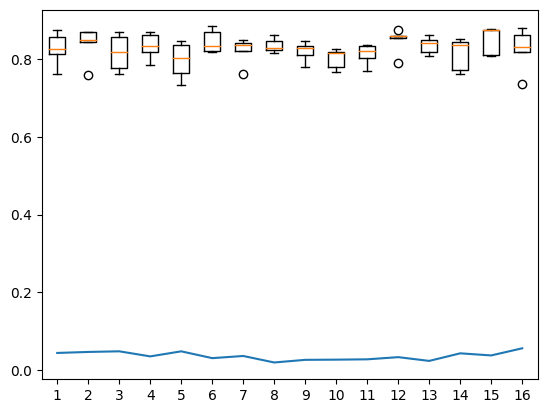

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"square_mask(150, 150)1",0.827780,0.043578
"square_mask(150, 150)2",0.839288,0.046140
"square_mask(250, 250)1",0.817283,0.047785
"square_mask(250, 250)2",0.834522,0.034695
"circle_mask(150, 150)1",0.797552,0.047727
"circle_mask(150, 150)2",0.846249,0.030186
"circle_mask(250, 250)1",0.822354,0.035733
"circle_mask(250, 250)2",0.836579,0.018994
"cross_mask(150, 150)1",0.821015,0.025786
"cross_mask(150, 150)2",0.802450,0.026284


We save the results in order to plot them together.

In [ ]:
folds = [["AM" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("ArtMix")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


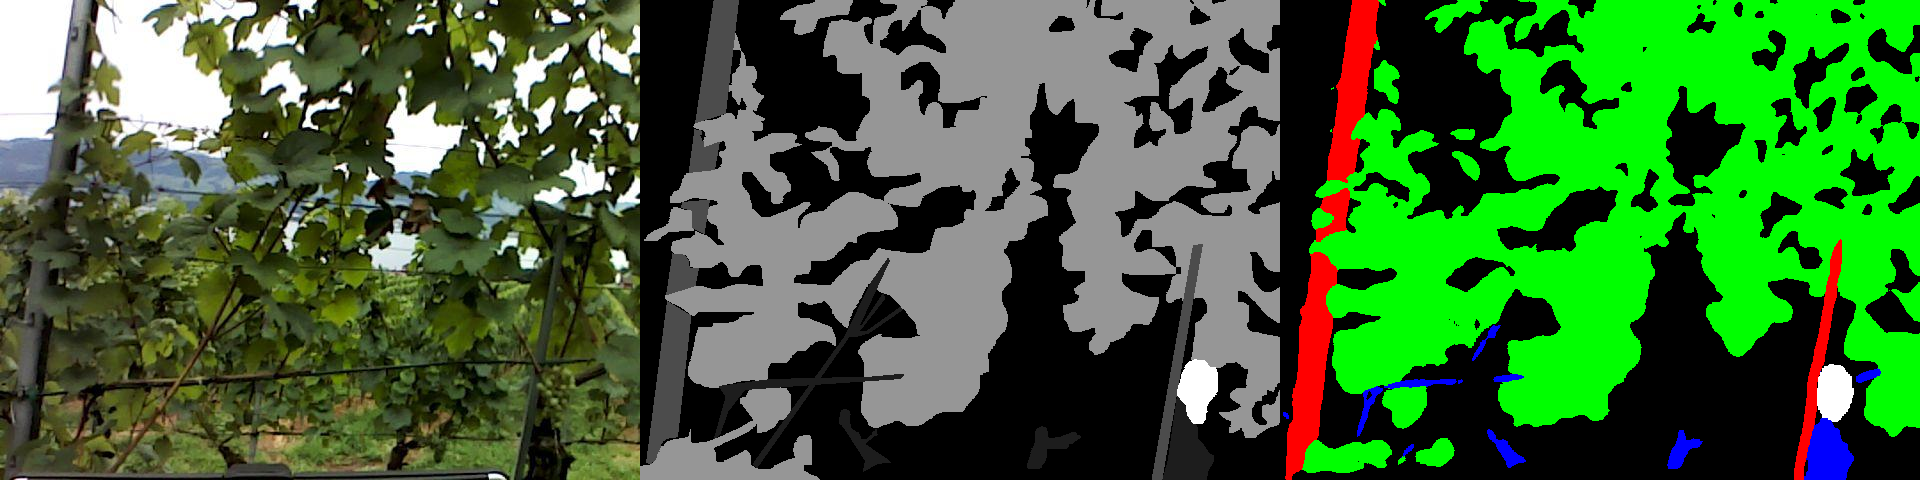

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

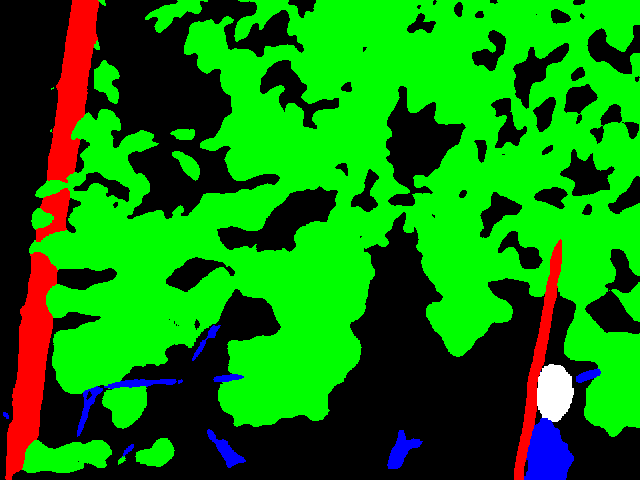

In [ ]:
mask